# Plot

In [14]:
!pip install plotnine pandas -q

In [15]:
import pandas as pd,os
import plotnine as p9
import warnings
warnings.filterwarnings('ignore')
p9.options.figure_size=(11,8)

## Load data

In [16]:
df_all = pd.read_csv('../synthesis/data.jobcensus.synthesized.2020-11-23.csv')
df_alias = pd.read_csv('../synthesis/data.jobcensus.field_aliases.csv')
df=df_all.merge(df_alias,on='JobField')
df['JobYear']=df['JobYear'].apply(int)
df

,JobTitle,JobYear,JobLink,JobType,JobField,JobSource,JobLink_norm,FieldAlias,Count
0,"Bard College (Annandale-on-Hudson, NY)",2011,NaN,TT,Medieval,Wiki,NaN,Medieval,202
1,"Bowdoin College (Brunswick, ME)",2011,NaN,Unknown,Medieval,Wiki,NaN,Medieval,202
2,"Boston College (Chestnut Hill, MA)",2011,NaN,TT,Medieval,Wiki,NaN,Medieval,202
3,"Brown University (Providence, RI)",2011,http://chronicle.com/jobs/0000646693-01/,Unknown,Medieval,Wiki,http://chronicle.com/jobs/0000646693-01/,Medieval,202
4,"Central Methodist University (Fayette, MO)",2011,http://www.higheredjobs.com/faculty/details.cf...,TT,Medieval,Wiki,http://www.higheredjobs.com/faculty/details.cf...,Medieval,202
...,...,...,...,...,...,...,...,...,...
14249,Associate Professor Poetry,2020,https://joblist.mla.org/job-details/2761/assoc...,TT,Poetry,JIL,https://joblist.mla.org/job-details/2761,Poetry,2
14250,"Assistant Professor in Asian American, Pacific...",2020,https://joblist.mla.org/job-details/2685/assis...,TT,Asian,JIL,https://joblist.mla.org/job-details/2685,Critical Race Studies,1
14251,Visiting Faculty Position in Japanese at Benni...,2020,https://joblist.mla.org/job-details/2699/visit...,Non-TT,Japanese,JIL,https://joblist.mla.org/job-details/2699,Languages,1
14252,Professorships in Race in Art & Design (Libera...,2020,https://joblist.mla.org/job-details/2772/profe...,TT,Critical Race Studies,JIL,https://joblist.mla.org/job-details/2772,Critical Race Studies,1


In [27]:
# filter
dfm = df
dfm = dfm[dfm.FieldAlias!='--']
dfm

,JobTitle,JobYear,JobLink,JobType,JobField,JobSource,JobLink_norm,FieldAlias,Count
0,"Bard College (Annandale-on-Hudson, NY)",2011,NaN,TT,Medieval,Wiki,NaN,Medieval,202
1,"Bowdoin College (Brunswick, ME)",2011,NaN,Unknown,Medieval,Wiki,NaN,Medieval,202
2,"Boston College (Chestnut Hill, MA)",2011,NaN,TT,Medieval,Wiki,NaN,Medieval,202
3,"Brown University (Providence, RI)",2011,http://chronicle.com/jobs/0000646693-01/,Unknown,Medieval,Wiki,http://chronicle.com/jobs/0000646693-01/,Medieval,202
4,"Central Methodist University (Fayette, MO)",2011,http://www.higheredjobs.com/faculty/details.cf...,TT,Medieval,Wiki,http://www.higheredjobs.com/faculty/details.cf...,Medieval,202
...,...,...,...,...,...,...,...,...,...
14249,Associate Professor Poetry,2020,https://joblist.mla.org/job-details/2761/assoc...,TT,Poetry,JIL,https://joblist.mla.org/job-details/2761,Poetry,2
14250,"Assistant Professor in Asian American, Pacific...",2020,https://joblist.mla.org/job-details/2685/assis...,TT,Asian,JIL,https://joblist.mla.org/job-details/2685,Critical Race Studies,1
14251,Visiting Faculty Position in Japanese at Benni...,2020,https://joblist.mla.org/job-details/2699/visit...,Non-TT,Japanese,JIL,https://joblist.mla.org/job-details/2699,Languages,1
14252,Professorships in Race in Art & Design (Libera...,2020,https://joblist.mla.org/job-details/2772/profe...,TT,Critical Race Studies,JIL,https://joblist.mla.org/job-details/2772,Critical Race Studies,1


## Plot 0: All jobs

In [33]:
df_count0 = dfm[dfm.JobType!='Postdoc'].groupby(['JobYear']).count().reset_index()
# df_count0

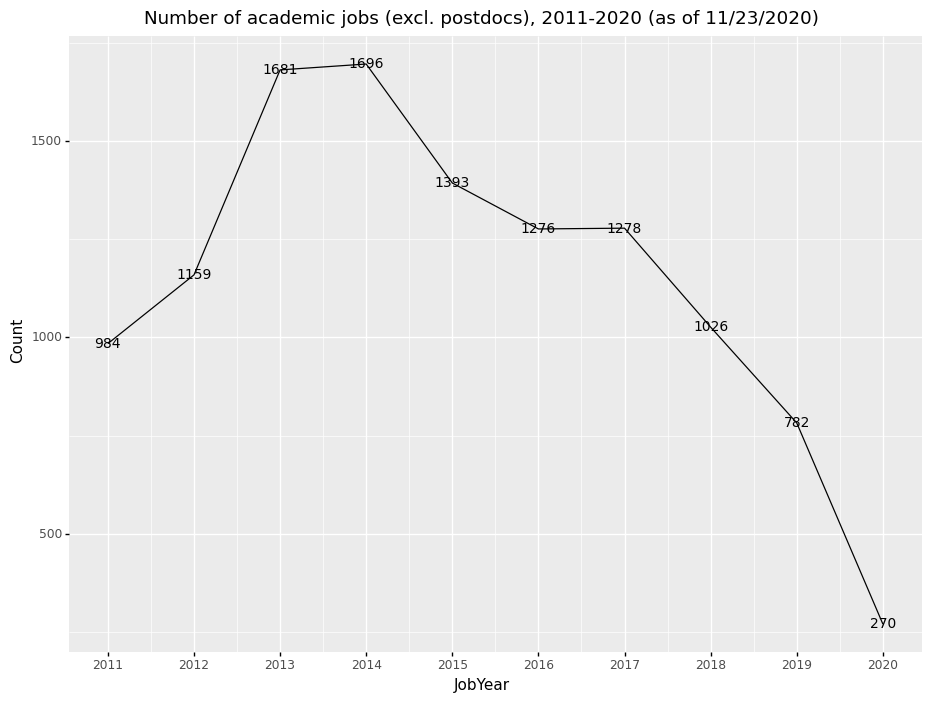

<ggplot: (317064521)>

In [37]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count'),df_count0) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle('Number of academic jobs (excl. postdocs), 2011-2020 (as of 11/23/2020)')
)
fig.save('figures/fig0.num_jobs.png',dpi=300)
fig

## Plot 1: By job type

In [18]:
df_count = dfm.groupby(['JobType','JobYear']).count().reset_index()
# df_count

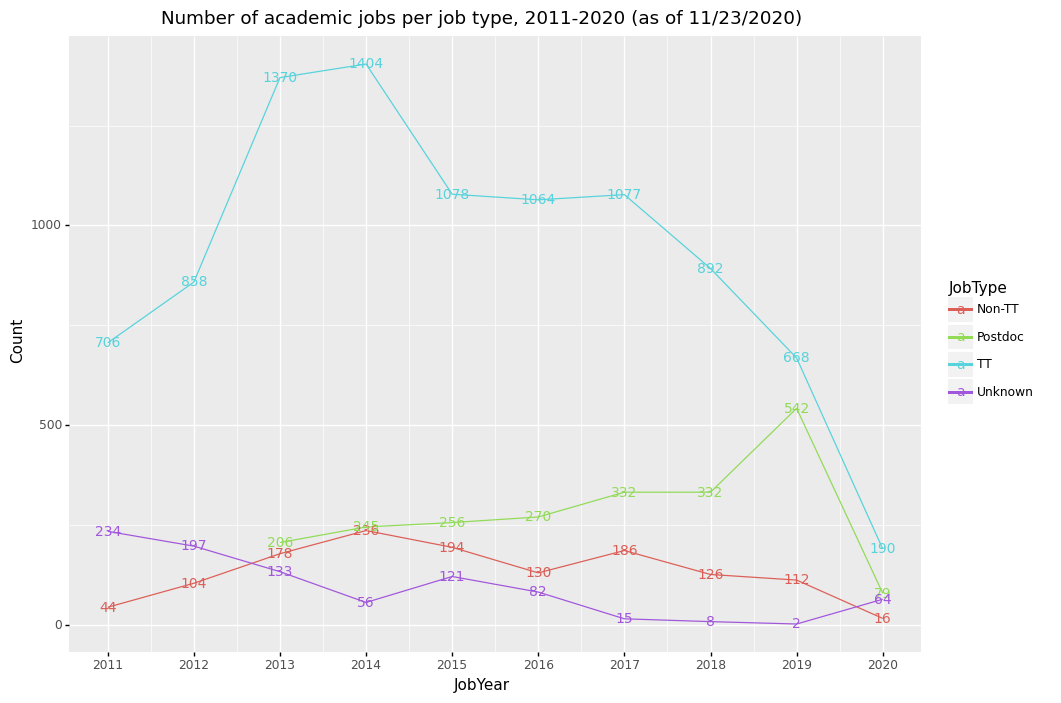

<ggplot: (316129244)>

In [38]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='JobType'),df_count) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle('Number of academic jobs per job type, 2011-2020 (as of 11/23/2020)')
)
fig.save('figures/fig1.num_jobs_per_type.png',dpi=300)
fig

## Plot 2: By field (top 10)

In [20]:
df_count2 = dfm.groupby(['JobYear','FieldAlias']).count().reset_index()
df_count2

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobLink_norm,Count
0,2011,American: C19/Early,60,49,60,60,60,49,60
1,2011,American: C20-C21,65,62,65,65,65,62,65
2,2011,Anglophone/Postcolonial,33,28,33,33,33,28,33
3,2011,British Open,16,15,16,16,16,15,16
4,2011,British: C17-C18,42,36,42,42,42,36,42
...,...,...,...,...,...,...,...,...,...
225,2020,Postdoc,82,53,82,82,82,53,82
226,2020,Rhetoric/Composition,33,32,33,33,33,32,33
227,2020,Theatre/Drama/Film,10,10,10,10,10,10,10
228,2020,Translation Studies,3,2,3,3,3,2,3


In [21]:
top10 = dfm[dfm.JobType!='Postdoc'].FieldAlias.value_counts().iloc[:10].index
top10

Index(['Rhetoric/Composition', 'Creative Writing', 'Theatre/Drama/Film',
       'Critical Race Studies', 'Generalist', 'Gender Studies', 'Early Modern',
       'Anglophone/Postcolonial', 'Community Colleges', 'Medieval'],
      dtype='object')

In [22]:
df_top10 = df_count2[df_count2.FieldAlias.isin(top10)]
df_top10

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobLink_norm,Count
2,2011,Anglophone/Postcolonial,33,28,33,33,33,28,33
7,2011,Community Colleges,6,2,6,6,6,2,6
9,2011,Creative Writing,156,128,156,156,156,128,156
10,2011,Critical Race Studies,67,49,67,67,67,49,67
12,2011,Early Modern,78,66,78,78,78,66,78
...,...,...,...,...,...,...,...,...,...
218,2020,Gender Studies,8,4,8,8,8,4,8
219,2020,Generalist,4,3,4,4,4,3,4
222,2020,Medieval,3,3,3,3,3,3,3
226,2020,Rhetoric/Composition,33,32,33,33,33,32,33


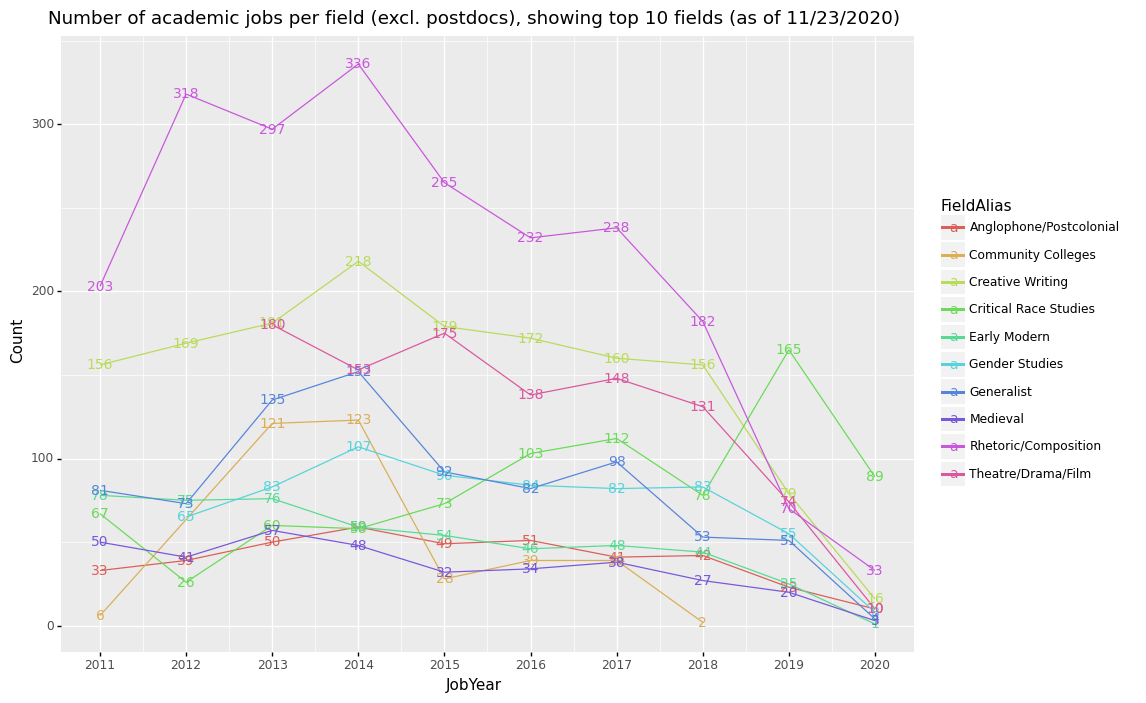

<ggplot: (316129250)>

In [39]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='FieldAlias'), df_top10)
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'), size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle('Number of academic jobs per field (excl. postdocs), showing top 10 fields (as of 11/23/2020)')
)
fig.save('figures/fig2.num_jobs_per_field_top10.png',dpi=300)
fig

## Plot 3: By field (all)

In [24]:
df_count3=dfm[dfm.JobType!='Postdoc'].groupby(['JobYear','FieldAlias']).count().reset_index()
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Unknown')]

# not consistently tracked by wiki:
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Languages')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Communication/Media Studies')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Poetry')] # not tracked by wiki data

In [25]:
# add zeros
unique_years = set(df_count3.JobYear)
missing_ld=[]
for field,fielddf in df_count3.groupby('FieldAlias'):
    field_years = set(fielddf.JobYear)
    for year in unique_years - field_years:
        dx=dict(fielddf.iloc[0])
        dx['JobYear']=year
        for k,v in dx.items():
            if not k in {'JobYear','FieldAlias'}:# and type(v)==int:
                dx[k]=0
        missing_ld.append(dx)
df_missing=pd.DataFrame(missing_ld)
df_count3=df_count3.append(df_missing)
df_count3

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobLink_norm,Count
0,2011,American: C19/Early,60,49,60,60,60,49,60
1,2011,American: C20-C21,65,62,65,65,65,62,65
2,2011,Anglophone/Postcolonial,33,28,33,33,33,28,33
3,2011,British Open,16,15,16,16,16,15,16
4,2011,British: C17-C18,42,36,42,42,42,36,42
...,...,...,...,...,...,...,...,...,...
31,2011,Translation Studies,0,0,0,0,0,0,0
32,2012,Translation Studies,0,0,0,0,0,0,0
33,2013,Translation Studies,0,0,0,0,0,0,0
34,2014,Translation Studies,0,0,0,0,0,0,0


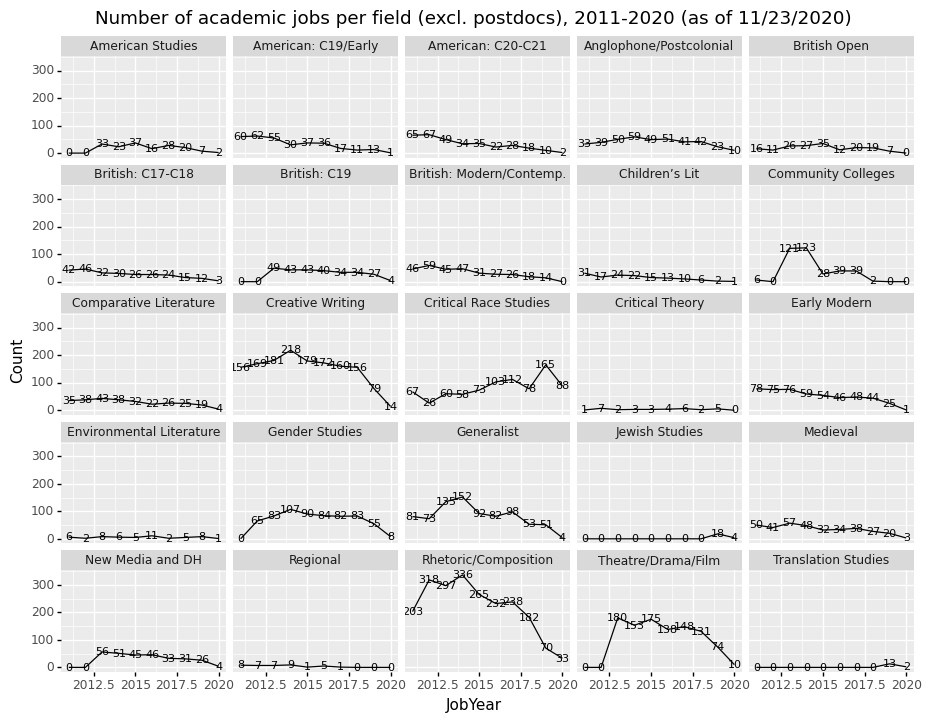

<ggplot: (317049938)>

In [40]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count'), df_count3[df_count3.FieldAlias!='Postdoc'])
    + p9.geom_line()
    + p9.facet_wrap('FieldAlias')
    + p9.geom_text(p9.aes(label='Count'),size=8)
    + p9.ggtitle('Number of academic jobs per field (excl. postdocs), 2011-2020 (as of 11/23/2020)')
)
fig.save('figures/fig3.num_jobs_per_field_all.png',dpi=300)
fig